In [20]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# --- Load data ---
df_country = pd.read_csv("noise_exposure_country_level.csv")

# Ensure numeric
df_country["Population"] = pd.to_numeric(df_country["Population"], errors="coerce")
df_country["Total_Lden"] = pd.to_numeric(df_country["Total_Lden"], errors="coerce")
df_country["Total_Lnight"] = pd.to_numeric(df_country["Total_Lnight"], errors="coerce")

# --- Global style settings ---
font_family = "Arial"
title_x = 0.5   # center titles
template = "plotly_white"


In [21]:
# Format values as whole numbers for annotation
text_values = (
    heatmap_data.fillna(0)     # replace NaN with 0
    .round(0)                  # round to whole numbers
    .astype(int)               # convert to integers
    .astype(str) + "%"         # add percentage sign
)


In [22]:
# Format values as whole numbers for annotation, but hide zeros
text_values = (
    heatmap_data.fillna(0)        # replace NaN with 0
    .round(0)                     # round to whole numbers
    .astype(int)                  # convert to integers
)

# Replace zeros with empty strings, others with "xx%"
text_values = text_values.applymap(lambda x: "" if x == 0 else f"{x}%")


C:\Users\amali\AppData\Local\Temp\ipykernel_19768\3218926446.py:9: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



### Visualization 1: % of population exposed to Lden > 55 dB (by Country)
“This chart shows the share of each country’s population regularly exposed to high daytime noise (above 55 dB). It highlights where noise is not just widespread but disproportionately affects people’s daily lives.”

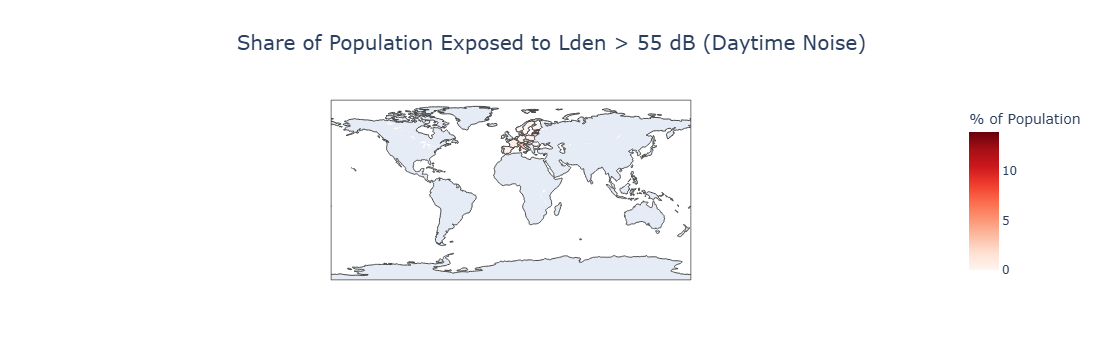

In [28]:
# ========================
# 1. Choropleth map - % of population exposed
# ========================
fig1 = px.choropleth(
    df_country,
    locations="Country",
    locationmode="country names",
    color="Total_Lden_pct",   # <-- fix here
    hover_name="Country",
    color_continuous_scale="Reds",
    title="Share of Population Exposed to Lden > 55 dB (Daytime Noise)",
    labels={"Total_Lden_pct": "% of Population"}
)

fig1.update_layout(title_x=0.5, title_font=dict(size=20))

# Save as high-resolution PNG
fig1.write_image("viz1_percent_population_exposed.png", scale=3, width=2000, height=1200)

fig1.show()



### Visualization 2: Absolute population exposed (Top 10 Countries)
“Here we see the actual number of people exposed. Even if a smaller share of the population is affected, large countries can still contribute millions of people to the total noise burden.”

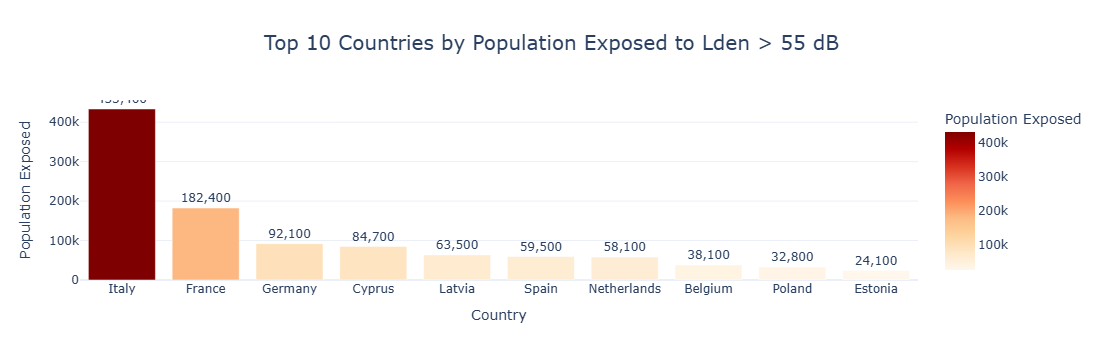

In [24]:
df_country["Total_Lden"] = pd.to_numeric(df_country["Total_Lden"], errors="coerce")
df_top10 = df_country.sort_values("Total_Lden", ascending=False).head(10)

fig2 = px.bar(
    df_top10,
    x="Country",
    y="Total_Lden",
    text="Total_Lden",
    title="Top 10 Countries by Population Exposed to Lden > 55 dB",
    labels={"Total_Lden": "Population Exposed"},
    template="plotly_white",
    color="Total_Lden",
    color_continuous_scale="OrRd"
)
fig2.update_traces(texttemplate="%{text:,.0f}", textposition="outside")
fig2.update_layout(yaxis_title="Population Exposed", xaxis_title="Country", title_x=0.5, title_font=dict(size=20))
fig2.write_image("viz2_population_exposed.png", scale=3, width=2000, height=1200)

fig2.show()

### Visualization 3: Daytime vs Nighttime Exposure (bubble plot)
“This scatter compares daytime and nighttime exposure. Countries above the diagonal line experience relatively more nighttime disturbance—often linked to sleep disruption and health risks.”

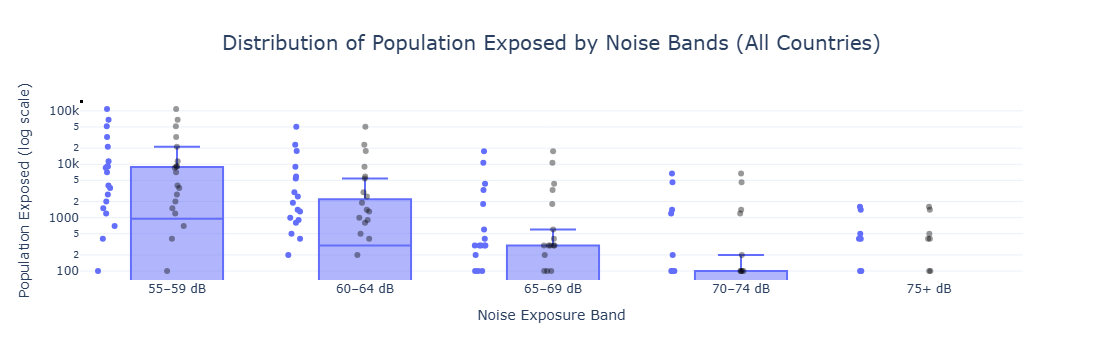

In [25]:
# Define mapping for prettier labels
band_labels = {
    "Lden_55_59": "55–59 dB",
    "Lden_60_64": "60–64 dB",
    "Lden_65_69": "65–69 dB",
    "Lden_70_74": "70–74 dB",
    "Lden_over_75": "75+ dB"
}

exposure_cols = list(band_labels.keys())

# Melt the dataframe
df_melted = df_country.melt(
    id_vars="Country",
    value_vars=exposure_cols,
    var_name="Noise Band",
    value_name="Exposed"
)

# Replace raw codes with nice labels
df_melted["Noise Band"] = df_melted["Noise Band"].map(band_labels)

# Create enhanced box plot
fig3 = px.box(
    df_melted,
    x="Noise Band",
    y="Exposed",
    title="Distribution of Population Exposed by Noise Bands (All Countries)",
    labels={"Exposed": "Population Exposed"},
    template="plotly_white",
    points="all",          # Show all points
    boxmode="overlay"       # Overlay medians & distributions
)

# Add jittered scatter points for clarity
fig3.add_trace(
    px.strip(
        df_melted,
        x="Noise Band",
        y="Exposed",
        color_discrete_sequence=["rgba(0,0,0,0.4)"], # grey transparent dots
        stripmode="overlay"
    ).data[0]
)

# Layout adjustments
fig3.update_layout(
    title_x=0.5,
    title_font=dict(size=20),
    xaxis_title="Noise Exposure Band",
    yaxis_title="Population Exposed (log scale)",
    yaxis_type="log"
)

# Save high-resolution
fig3.write_image("viz3_distribution_noise_bands_log_jitter.png", scale=3, width=2000, height=1200)
fig3.show()



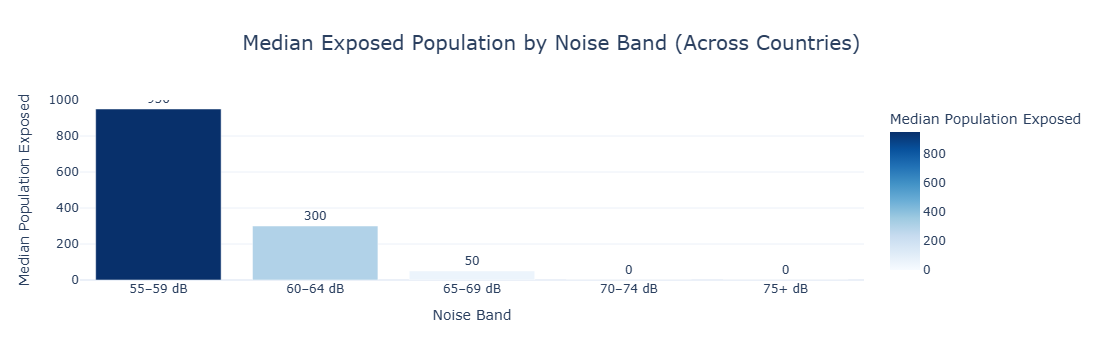

In [26]:
# --- Calculate median exposure per noise band ---
band_medians = (
    df_melted.groupby("Noise Band")["Exposed"]
    .median()
    .sort_values(ascending=False)
    .reset_index()
)

# --- Create bar chart ---
fig4 = px.bar(
    band_medians,
    x="Noise Band",
    y="Exposed",
    title="Median Exposed Population by Noise Band (Across Countries)",
    labels={"Exposed": "Median Population Exposed"},
    text="Exposed",
    template="plotly_white",
    color="Exposed",
    color_continuous_scale="Blues"
)

fig4.update_traces(texttemplate="%{text:,.0f}", textposition="outside")
fig4.update_layout(title_x=0.5, title_font=dict(size=20))

# --- Save as high-resolution PNG ---
fig4.write_image(
    "viz4_median_population_by_noise_band.png",
    scale=3,  # higher scale = sharper image
    width=1000,
    height=600
)


fig4.show()



### Visualization 5: Noise Exposure Distribution (stacked bar per country)
“Finally, this stacked chart shows not just how many are exposed, but how severely. Some countries have a large portion of people in the very high noise bands (above 70 dB), which can signal chronic health concerns.”

C:\Users\amali\AppData\Local\Temp\ipykernel_19768\1553789615.py:31: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



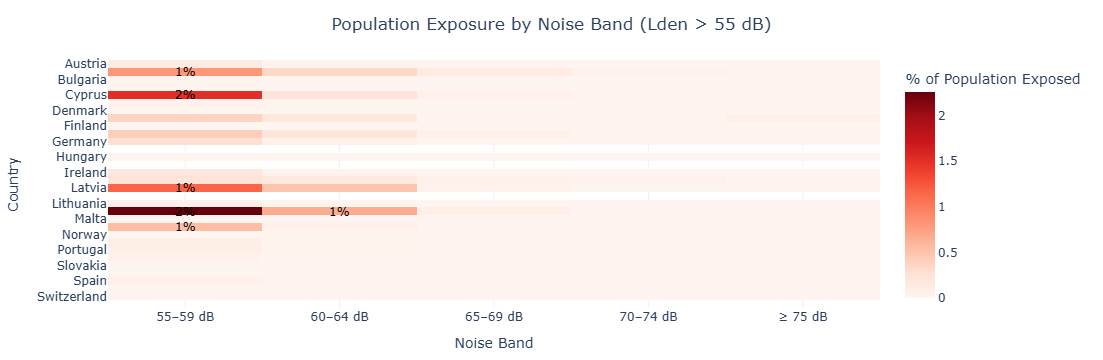

In [30]:
import pandas as pd
import plotly.express as px

# --- Define exposure percentage columns for heatmap ---
heatmap_cols = [
    "Lden_55_59_pct",
    "Lden_60_64_pct",
    "Lden_65_69_pct",
    "Lden_70_74_pct",
    "Lden_over_75_pct"
]

# Subset for heatmap
heatmap_data = df_country.set_index("Country")[heatmap_cols]

# Rename columns for cleaner axis labels
band_order = {
    "Lden_55_59_pct": "55–59 dB",
    "Lden_60_64_pct": "60–64 dB",
    "Lden_65_69_pct": "65–69 dB",
    "Lden_70_74_pct": "70–74 dB",
    "Lden_over_75_pct": "≥ 75 dB"
}
heatmap_data = heatmap_data.rename(columns=band_order)

# Format values for annotation (hide zeros, show % otherwise)
text_values = (
    heatmap_data.fillna(0)
    .round(0)
    .astype(int)
    .applymap(lambda x: "" if x == 0 else f"{x}%")
)

# --- Plot heatmap with labels ---
fig5 = px.imshow(
    heatmap_data,
    color_continuous_scale="Reds",
    aspect="auto",
    labels=dict(x="Noise Band", y="Country", color="% of Population Exposed"),
    text_auto=False
)

# Add annotations manually
for i, country in enumerate(heatmap_data.index):
    for j, band in enumerate(heatmap_data.columns):
        value = text_values.iloc[i, j]
        if value != "":
            fig5.add_annotation(
                x=band,
                y=country,
                text=value,
                showarrow=False,
                font=dict(color="black", size=12)
            )

fig5.update_layout(
    title="Population Exposure by Noise Band (Lden > 55 dB)",
    title_x=0.5,
    template="plotly_white",
    margin=dict(l=40, r=40, t=60, b=40)
)

# Save as PNG (high resolution)
fig5.write_image("viz5_heatmap.png", scale=3)

fig5.show()

